# Fake Or News?

## 1. Colab Mount

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## 2. Library Imports

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import tqdm
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import *

## 3. Data

In [0]:
fake = pd.read_csv("/content/gdrive/My Drive/fake_news/Fake.csv").reset_index()
fake.drop(['title', 'date', 'subject'],axis = 1, inplace = True)
fake['category'] = 0

In [0]:
true = pd.read_csv("/content/gdrive/My Drive/fake_news/True.csv").reset_index()
true.drop(['title', 'date', 'subject'],axis = 1, inplace = True)
true['category'] = 1

In [0]:
unknown_publishers = []
for index,row in enumerate(true.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [8]:
true.iloc[unknown_publishers].text

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [0]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(true.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [0]:
true['text'] = tmp_text

In [0]:
true.drop(8970, axis = 0, inplace = True) # empty text row

In [0]:
np.random.seed(123) # seed

In [13]:
fake.head()

,index,text,category
0,0,Donald Trump just couldn t wish all Americans ...,0
1,1,House Intelligence Committee Chairman Devin Nu...,0
2,2,"On Friday, it was revealed that former Milwauk...",0
3,3,"On Christmas day, Donald Trump announced that ...",0
4,4,Pope Francis used his annual Christmas Day mes...,0


In [0]:
true.head()

,index,text,category
0,0,The head of a conservative Republican faction...,1
1,1,Transgender people will be allowed for the fi...,1
2,2,The special counsel investigation of links be...,1
3,3,Trump campaign adviser George Papadopoulos to...,1
4,4,President Donald Trump called on the U.S. Pos...,1


### shuffling

In [0]:
f_sample_list = random.sample(list(fake.index), 4000)

In [0]:
fake_sub = fake.loc[f_sample_list]

In [0]:
fake_m = fake.query('index not in @f_sample_list')

In [0]:
t_sample_list = random.sample(list(true.index), 4000)

In [0]:
true_sub = true.loc[t_sample_list]

In [0]:
true_m = true.query('index not in @t_sample_list')

### concatenate

In [0]:
Train = pd.concat([fake_m, true_m], axis = 0)
Train.index = range(0, len(Train))

In [0]:
Test = pd.concat([fake_sub, true_sub], axis = 0)
Test.index = range(0, len(Test))

In [0]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36897 entries, 0 to 36896
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     36897 non-null  int64 
 1   text      36897 non-null  object
 2   category  36897 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 864.9+ KB


In [0]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     8000 non-null   int64 
 1   text      8000 non-null   object
 2   category  8000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 187.6+ KB


In [0]:
Train.text = Train.text.apply(lambda x : x.lower())

In [0]:
Test.text = Test.text.apply(lambda x : x.lower())

In [0]:
train_clear_text = list(Train.text)
train_clear_text2 = []

for word in train_clear_text:
  temp = re.sub('[-=+,#:;//●<>▲\?:^$.☆!★()Ⅰ@*\"※~>`\'…》]', ' ', word)
  train_clear_text2.append(temp)
Train['clear_text'] = train_clear_text2

In [0]:
test_clear_text = list(Test.text)
test_clear_text2 = []

for word in test_clear_text:
  temp = re.sub('[-=+,#:;//●<>▲\?:^$.☆!★()Ⅰ@*\"※~>`\'…》]', ' ', word)
  test_clear_text2.append(temp)
Test['clear_text'] = test_clear_text2

## 4. Tokenizing

In [30]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [0]:
token_list = []

for word in Train.clear_text:
  temp = word_tokenize(word)
  temp = [w for w in temp if not w in stop]
  token_list.append(temp)

In [0]:
Train['token_text'] = token_list

In [0]:
token_list = []

for word in Test.clear_text:
  temp = word_tokenize(word)
  temp = [w for w in temp if not w in stop]
  token_list.append(temp)

In [0]:
Test['token_text'] = token_list

In [86]:
train_token = list(Train.token_text)

token = []

for i in tqdm(range(len(Train))):
  token.append(re.sub("[',]", '', str(Train.token_text[i])[1:-1]))

Train['token_text'] = token

100%|██████████| 36897/36897 [00:05<00:00, 6708.83it/s]


In [87]:
Train.token_text[0][:]

'donald trump wish americans happy new year leave instead give shout enemies haters dishonest fake news media former reality show star one job country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year president angry pants tweeted 2018 great year america country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year 2018 great year america donald j trump realdonaldtrump december 31 2017trump tweet went welll expect kind president sends new year greeting like despicable petty infantile gibberish trump lack decency even allow rise gutter long enough wish american citizens happy new year bishop talbert swan talbertswan december 31 2017no one likes calvin calvinstowell december 31 2017your impeachment would make 2018 great year america also accept regaining control congress miranda yaver mirandayaver december 31 2017do hear talk include ma

In [82]:
test_token = list(Test.token_text)

token = []

for i in tqdm(range(len(Test))):
  token.append(re.sub("[',]", '', str(Test.token_text[i])[1:-1]))
Test['token_text'] = token

100%|██████████| 8000/8000 [00:01<00:00, 6491.99it/s]


### reshuffling

In [0]:
Train = Train.sample(frac = 1)
Test = Test.sample(frac = 1)

In [89]:
Train.head()

,index,text,category,clear_text,token_text
12999,15731,it s interesting that josh earnest still carri...,0,it s interesting that josh earnest still carri...,interesting josh earnest still carries around ...
30829,13880,families of the 44 crew members of a missing ...,1,families of the 44 crew members of a missing ...,families 44 crew members missing argentine sub...
29719,12531,ukrainian opposition figure mikheil saakashvi...,1,ukrainian opposition figure mikheil saakashvi...,ukrainian opposition figure mikheil saakashvil...
36501,20907,cambodia s government has raised the possibil...,1,cambodia s government has raised the possibil...,cambodia government raised possibility main op...
24850,6533,"omarosa manigault, best-known for repeatedly ...",1,omarosa manigault best known for repeatedly ...,omarosa manigault best known repeatedly fired ...


In [90]:
Test.head()

,index,text,category,clear_text,token_text
5027,2624,republicans in the u.s. senate were dealt ano...,1,republicans in the u s senate were dealt ano...,republicans u senate dealt another blow effort...
2944,6896,trump made a visit to the keystone state in an...,0,trump made a visit to the keystone state in an...,trump made visit keystone state effort bolster...
5955,1223,u.s. president donald trump will hurt low-inc...,1,u s president donald trump will hurt low inc...,u president donald trump hurt low income ameri...
957,6932,congresswoman debbie wasserman schultz s caree...,0,congresswoman debbie wasserman schultz s caree...,congresswoman debbie wasserman schultz career ...
5517,5935,u.s. president donald trump said on friday th...,1,u s president donald trump said on friday th...,u president donald trump said friday would def...


In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(Train.token_text))

In [92]:
threshold = 6
total_cnt = len(tokenizer.word_index) # the number of words
rare_cnt = 0 # Total number of words with less frequency than threshold
total_freq = 0 # Total total word frequency of training data
rare_freq = 0 # the sum of the total frequency of the appearance of a word with less than threshhold.


for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('size of vocab :',total_cnt)
print('Number of rare words with less than %s appearances : %s'%(threshold - 1, rare_cnt))
print("Percentage of rare words in vocab :", (rare_cnt / total_cnt)*100)
print("Percentage of rare word frequency from total frequency of appearance :", (rare_freq / total_freq)*100)

size of vocab : 112458
Number of rare words with less than 5 appearances : 73844
Percentage of rare words in vocab : 65.66362553130946
Percentage of rare word frequency from total frequency of appearance : 1.5287798777640993


In [93]:
vocab_size = total_cnt - rare_cnt + 1 # Remove the total number of words with a frequency of 5 or less. +1 considering padding token 0
print('size of vocab :',vocab_size)

size of vocab : 38615


In [0]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(list(Train.token_text))

In [0]:
token_X_train = tokenizer.texts_to_sequences(list(Train.token_text))
token_X_test = tokenizer.texts_to_sequences(list(Test.token_text))

In [0]:
drop_train = [index for index, sentence in enumerate(token_X_train) if len(sentence) < 1]

In [0]:
del_X_train = np.delete(token_X_train, drop_train, axis=0)
del_y_train = np.delete(list(Train.category), drop_train, axis = 0)

In [98]:
del_X_train.shape, del_y_train.shape

((36338,), (36338,))

In [99]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('Percentage of the total samples less than %s in length : %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 1000
below_threshold_len(max_len, del_X_train)

Percentage of the total samples less than 1000 in length : 99.29275138972976


In [0]:
pad_X_train = pad_sequences(del_X_train, maxlen = max_len)
pad_X_test = pad_sequences(token_X_test, maxlen = max_len)

Maximum text length : 4962
Average Text Length : 242.9076448896472


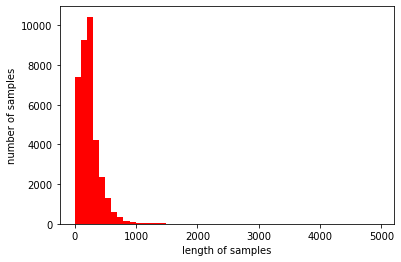

In [101]:
print('Maximum text length :',max(len(l) for l in del_X_train))
print('Average Text Length :',sum(map(len, del_X_train))/len(del_X_train))
plt.hist([len(s) for s in del_X_train], bins=50, color = 'r')
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Maximum text length :  4962
Average Text Length :  236.55025


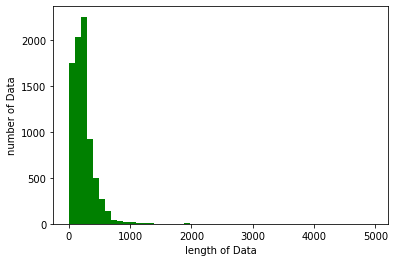

In [102]:
print("Maximum text length : ", max(len(l) for l in token_X_test))
print("Average Text Length : ", sum(map(len, token_X_test))/ len(token_X_test))
plt.hist([len(s) for s in token_X_test], bins=50, color = 'g')
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [103]:
import gc
gc.collect()

11219

## 5. Modeling

In [104]:
model_conv = Sequential()
model_conv.add(Embedding(vocab_size, 32, input_length=max_len))
model_conv.add(Dropout(0.3))
model_conv.add(Conv1D(32, 5, activation='relu'))
model_conv.add(GlobalMaxPooling1D())
#model_conv.add(LSTM(32))
model_conv.add(Dense(1, activation='sigmoid'))
model_conv.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 32)          1235680   
_________________________________________________________________
dropout (Dropout)            (None, 1000, 32)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 32)           5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,240,865
Trainable params: 1,240,865
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [106]:
history = model_conv.fit(pad_X_train, del_y_train, epochs=4, shuffle = True, validation_split= .1, batch_size = 128, verbose = 1)

Epoch 1/4
256/256 [==============================] - 8s 31ms/step - loss: 0.2727 - acc: 0.9345 - val_loss: 0.0471 - val_acc: 0.9895
Epoch 2/4
256/256 [==============================] - 8s 30ms/step - loss: 0.0285 - acc: 0.9926 - val_loss: 0.0258 - val_acc: 0.9912
Epoch 3/4
256/256 [==============================] - 8s 30ms/step - loss: 0.0117 - acc: 0.9972 - val_loss: 0.0219 - val_acc: 0.9917
Epoch 4/4
256/256 [==============================] - 8s 30ms/step - loss: 0.0052 - acc: 0.9992 - val_loss: 0.0205 - val_acc: 0.9920


In [108]:
pred = model_conv.predict(pad_X_test)
pred_list = []

for t in tqdm(range(len(pad_X_test))):
  pred_list.append(pred[t][0])

100%|██████████| 8000/8000 [00:00<00:00, 1071547.30it/s]


In [0]:
def bound(x):
  if x >= .55:
    return 1
  else:
    return 0

In [0]:
from sklearn.metrics import *

In [111]:
accuracy_score(Test.category, pd.Series(pred_list).map(bound))

0.994375

In [112]:
print(classification_report(Test.category, pd.Series(pred_list).map(bound)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4000
           1       0.99      0.99      0.99      4000

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000

